In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from gensim.models import Word2Vec
from sklearn.decomposition import PCA

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, InputLayer
from keras.layers.convolutional import Conv1D
from keras.layers.recurrent import SimpleRNN
from keras.layers.embeddings import Embedding

from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wGDjR3UsgIJTuYQ555axx_hNxC8sX7Ujphw1lUdhRJzPnnxhKpZeHw
Mounted at /content/drive


In [ ]:
PATH = '/content/'
FILE = f'{PATH}data_augmented_post_stopword.xlsx'

X0 = 'Final Data'
X1 = 'Short description'
X2 = 'Description'
X3 = 'Caller'
Y = 'Assignment group'
TARGET = 'target'

X4 = 'Word Count'
X5 = 'Short Word Count'

MODEL = 'ats.1k.20d.model'

SEED = 1

In [ ]:
data = pd.read_excel(FILE, engine='openpyxl')
data = data[data[X0].notna()]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10780 entries, 0 to 10786
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Short description  10773 non-null  object
 1   Description        10720 non-null  object
 2   Caller             10780 non-null  object
 3   Assignment group   10780 non-null  object
 4   Final Data         10780 non-null  object
 5   Word Count         10780 non-null  int64 
 6   Short Word Count   10780 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 673.8+ KB


In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Word Count,10780.0,20.166790,45.199085,1.0,6.0,11.0,22.0,1062.0
Short Word Count,10780.0,5.059555,2.641062,1.0,3.0,5.0,6.0,19.0


In [ ]:
text = [[text for text in doc.split()] for doc in data[X0].astype(str)]

In [ ]:
words = {}
for sentence in text:
  for word in sentence:
    if word in words:
      words[word] = words[word] + 1
    else:
      words[word] = 1

In [ ]:
words_df = pd.DataFrame(list(words.items()),columns = ['word','count'])

In [ ]:
words_df.describe().T

,count,mean,std,min,25%,50%,75%,max
count,11820.0,18.385364,93.0837,1.0,1.0,2.0,6.0,2969.0


In [ ]:
total_low_words_sentence = 0
for sentence in text:
  def check_low_word_count(sentence):
    for word in sentence:
      if words[word] >= 15:
        return False
    return True
  if check_low_word_count(sentence):
    print(sentence)
    total_low_words_sentence = total_low_words_sentence + 1

total_low_words_sentence

['missed']
['prtqi', 'malfunction']
['dds', 'dss']
['restoring', 'ppt']
['uninstall', 'google', 'chrome']
['splash', 'sensation', 'extends', 'big', 'jigsaw']
['ramdnty']
['recieve']


8

We have only 1 such sentences which has words with frequencies less than 5. Noticeable thing is that out of 11k words it has pruned down to just 3k words

In [ ]:
VECTOR_SIZE = 20
model = Word2Vec(text, sg=1, min_count=15, size=VECTOR_SIZE)

In [ ]:
len(model.wv.vectors)

1987

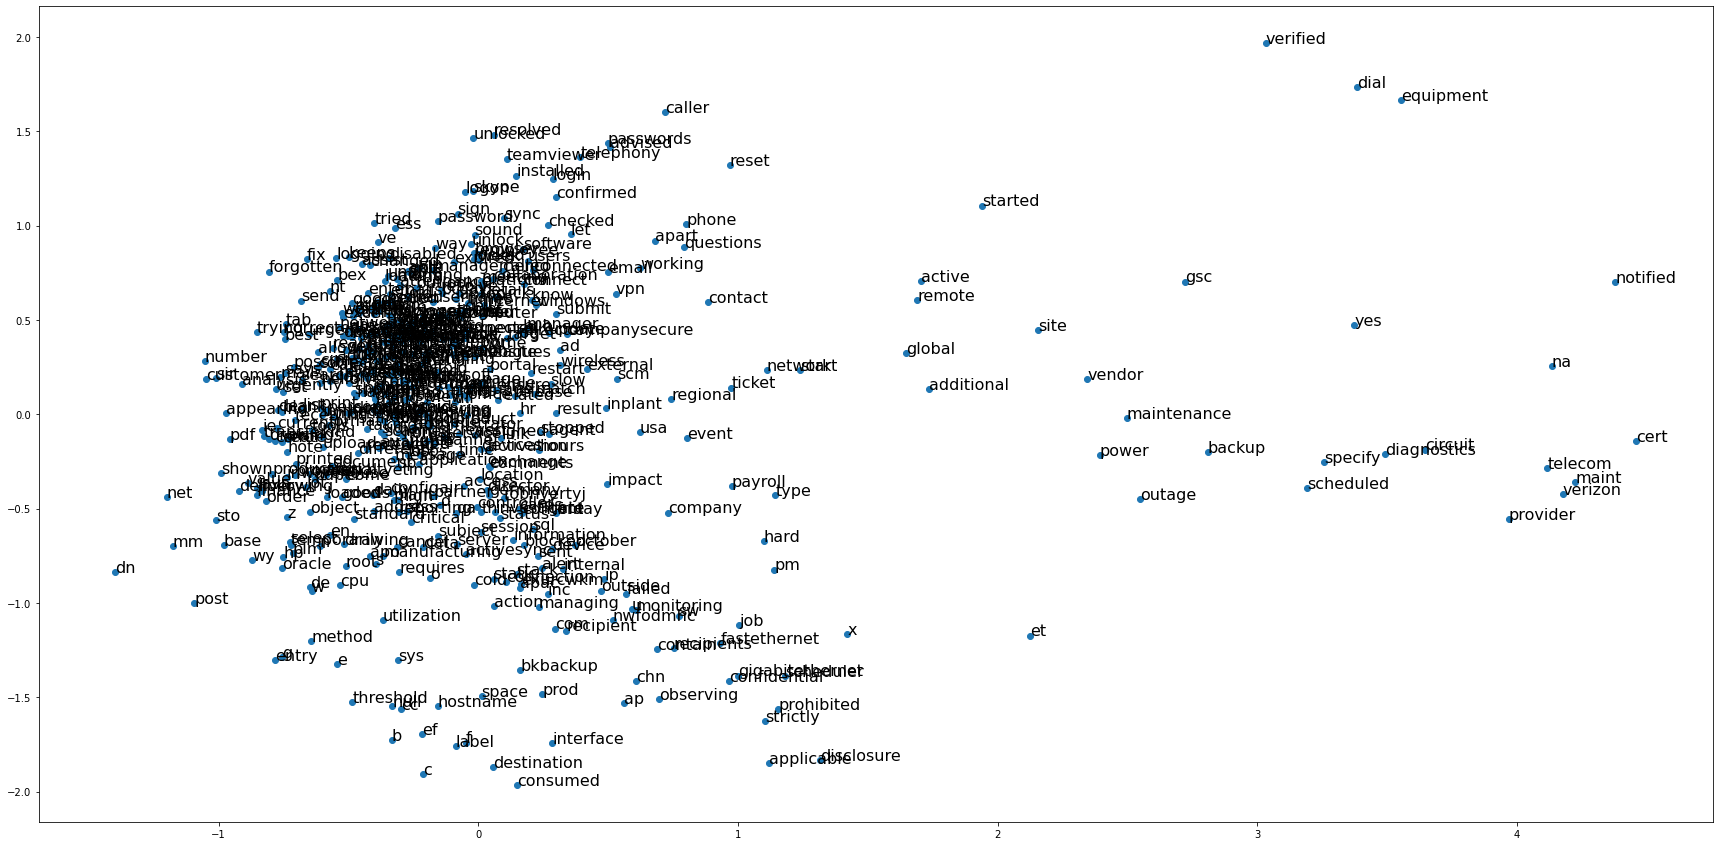

In [ ]:
def show_word_scatter(model, plot_limit):
    pca = PCA(n_components=2)
    result = pca.fit_transform(model.wv[model.wv.vocab][:plot_limit])

    size = (30,15)
    fig, ax = plt.subplots(figsize=size)

    ax = plt.scatter(result[:, 0], result[:, 1])

    words = list(model.wv.vocab)[:plot_limit]
    for i, word in enumerate(words):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]), fontsize=16)
    plt.show()

PLOT_LIMIT = 500
show_word_scatter(model, PLOT_LIMIT)

In [ ]:
model.save(MODEL)
ats_model = Word2Vec.load(MODEL)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
max_features = 500
maxlen = 30
embedding_size = VECTOR_SIZE

UNKNOWN = "<unknown>"
PADDING = "<padding>"

def tokenize(sentences, max_feat):
  special_token = 2
  tokenizer = Tokenizer(num_words=max_feat, lower=True, oov_token=UNKNOWN)
  tokenizer.fit_on_texts(sentences)
  tokenizer.word_index[PADDING] = 0
  tokenizer.index_word[0] = PADDING

  sequences = tokenizer.texts_to_sequences(sentences)
  # Since we are just considering 100 words atmost, we will not calculate malen and return it
  # maxlen = max([len(x) for x in sequences])
  return tokenizer, sequences

def pad_sentences(sentences, maxlen):
  return pad_sequences(sentences, maxlen=maxlen, padding='post').tolist()

def reshape_sentences(sentences, maxlen):
  return sentences.reshape(len(sentences), maxlen, 1)

In [ ]:
tokenizer, sequences = tokenize(data[X0].astype(str), max_features)
X = pad_sentences(sequences, maxlen)

print("\nPadded sequences:\n", X[10])
print("Sequences data type:", type(sequences))
print("Padded sequences data type:", type(X))

X = np.asarray(X)
X = reshape_sentences(X, maxlen)
print(type(X))
print(X.shape)

num_words = len(tokenizer.word_index) + 1
print(num_words)


Padded sequences:
 [53, 6, 1, 291, 18, 277, 328, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Sequences data type: <class 'list'>
Padded sequences data type: <class 'list'>
<class 'numpy.ndarray'>
(10780, 30, 1)
11823


In [ ]:
embedding_matrix = np.zeros((num_words, embedding_size))

In [ ]:
for word, i in tokenizer.word_index.items():
  try:
    embedding_vector = ats_model.wv.get_vector(word)
  except:
    embedding_vector = np.zeros(embedding_size)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [ ]:
labelEncoder = LabelEncoder()
data[TARGET] = labelEncoder.fit_transform(list(data[Y]))
CLASS = np.array(data[TARGET])

CATEGORIES = np.unique(CLASS)

In [ ]:
X_train_model, X_test, Y_train_model, Y_test = train_test_split(X, CLASS, stratify=CLASS, test_size=0.15, random_state=SEED)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_model, Y_train_model, test_size=0.1, random_state=SEED)

In [ ]:
print(X_train.shape)
print(X_test.shape)

total_classes = len(data[Y].unique()) - 1

(8246, 30, 1)
(1617, 30, 1)


In [ ]:
embedding_matrix.shape

(11823, 20)

In [ ]:
def buildRnnModel(num_words, embeddings, sentence_max_len):
  model = Sequential()
  model.add(Embedding(num_words, embeddings.shape[1], weights=[embeddings], input_length=sentence_max_len, trainable=False))

  #RNN
  model.add(SimpleRNN(units=16, activation='relu'))

  #FCNN
  model.add(Dense(units=32, input_dim = 16, activation='relu'))
  model.add(Dense(units=64, input_dim=32, activation='relu')) 
  model.add(Dense(units=1, input_dim=8, activation='softmax')) # Classification layer

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  print(model.summary())
  return model

In [ ]:
stop = EarlyStopping(monitor="val_accuracy", patience=5, mode="auto")
reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", factor=0.001, patience=5, min_lr=1e-10, verbose=1, mode="auto")

In [ ]:
rnn_model = buildRnnModel(num_words, embedding_matrix, maxlen)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 30, 20)            236460    
_________________________________________________________________
simple_rnn_8 (SimpleRNN)     (None, 16)                592       
_________________________________________________________________
dense_20 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_21 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 65        
Total params: 239,773
Trainable params: 3,313
Non-trainable params: 236,460
_________________________________________________________________
None


In [ ]:
rnn_model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=20, batch_size=100, callbacks=[reduce_lr, stop])

Epoch 1/20
83/83 [==============================] - 1s 9ms/step - loss: 0.0000e+00 - accuracy: 0.0027 - val_loss: 0.0000e+00 - val_accuracy: 0.0044
Epoch 2/20
83/83 [==============================] - 1s 6ms/step - loss: nan - accuracy: 0.0314 - val_loss: nan - val_accuracy: 0.3686
Epoch 3/20
83/83 [==============================] - 1s 7ms/step - loss: nan - accuracy: 0.3675 - val_loss: nan - val_accuracy: 0.3686
Epoch 4/20
83/83 [==============================] - 1s 7ms/step - loss: nan - accuracy: 0.3675 - val_loss: nan - val_accuracy: 0.3686
Epoch 5/20
83/83 [==============================] - 1s 7ms/step - loss: nan - accuracy: 0.3675 - val_loss: nan - val_accuracy: 0.3686
Epoch 6/20
83/83 [==============================] - 1s 7ms/step - loss: nan - accuracy: 0.3675 - val_loss: nan - val_accuracy: 0.3686
Epoch 7/20
79/83 [===========================>..] - ETA: 0s - loss: nan - accuracy: 0.3651
Epoch 00007: ReduceLROnPlateau reducing learning rate to 1.0000000474974512e-06.
83/83 [===

In [ ]:
scores = rnn_model.evaluate(X_test, Y_test)
print("Accuracy: %.2f%%" % (scores[1]*100))

51/51 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.3673
Accuracy: 36.73%
